Resultaten voor de standaardwaarden:
Optimale teamgrootte (n_opt): 5
Optimale incentiveparameter (b_opt): 30.435826383457304
Optimale monitoring effort (m_opt): 15.751357918095074
Maximale teamwinst: 795.053446068223
Aantal niveaus in hiërarchie: 3


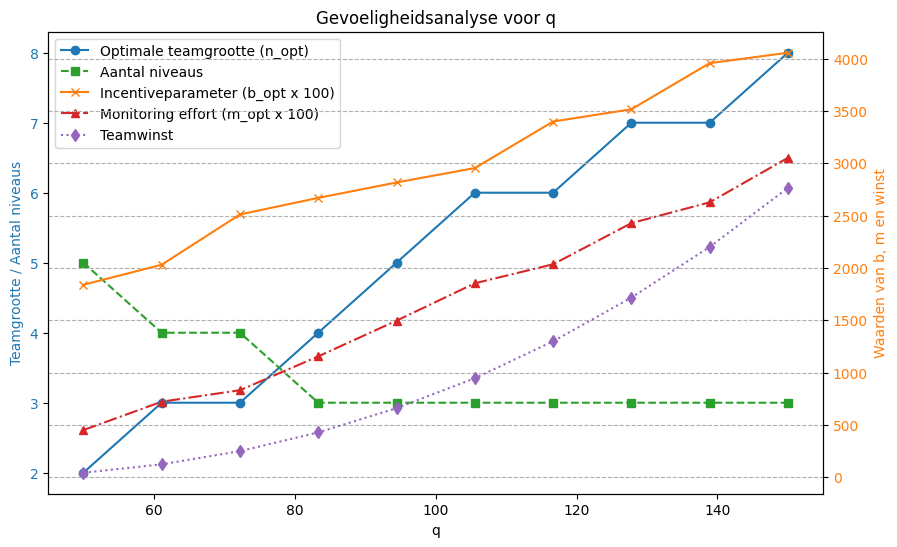

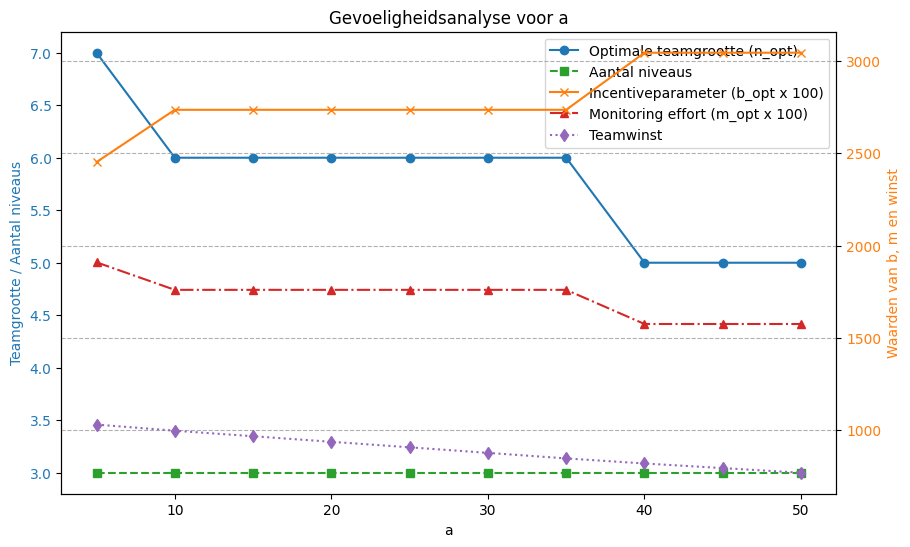

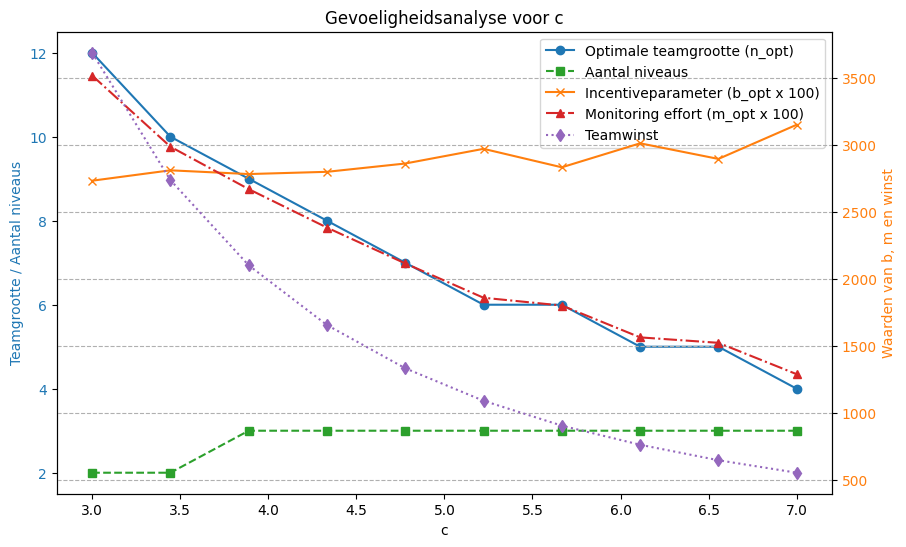

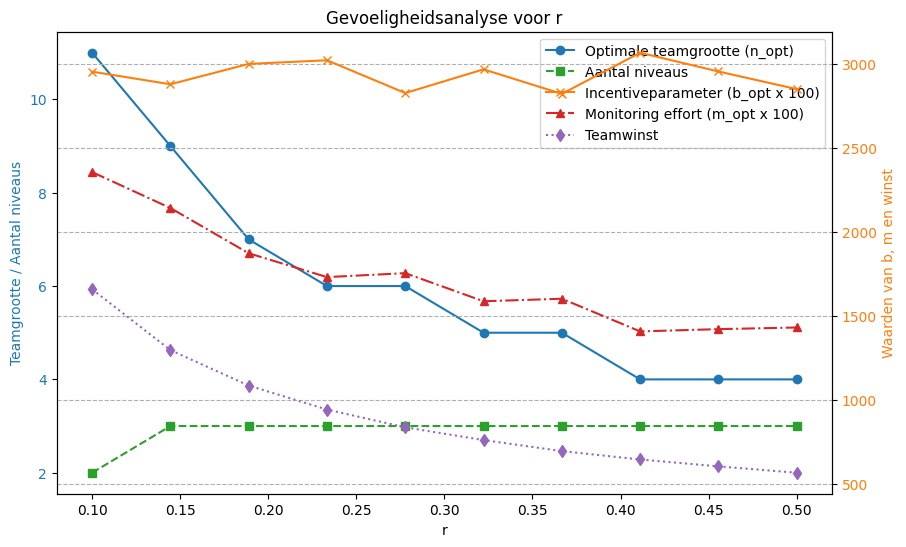

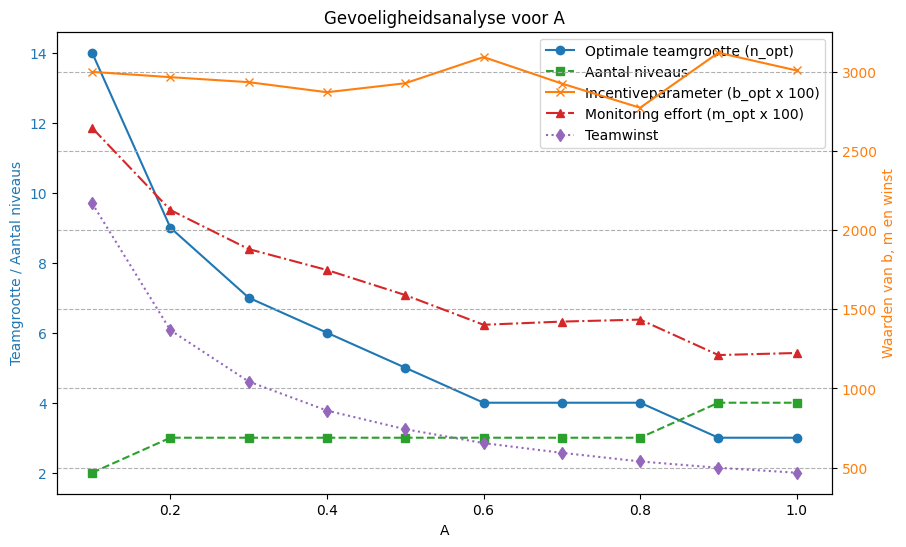

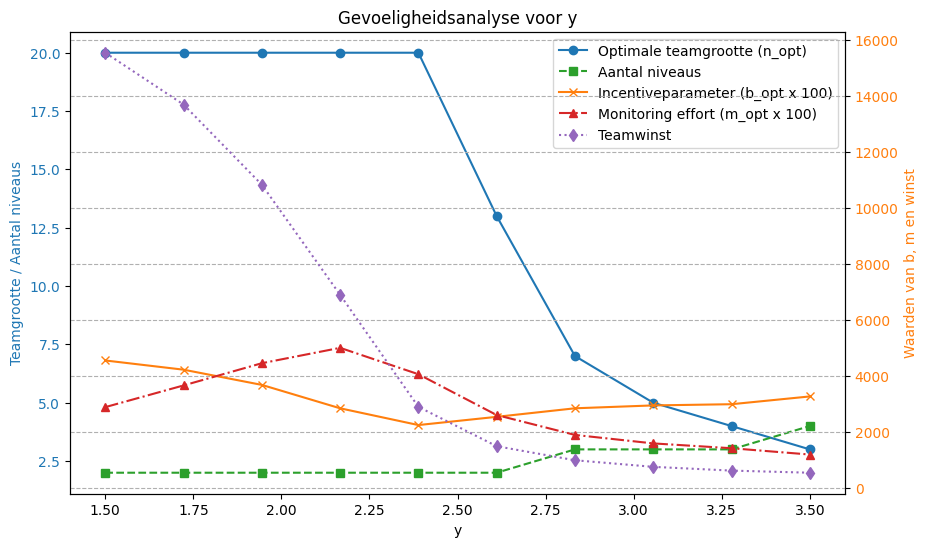

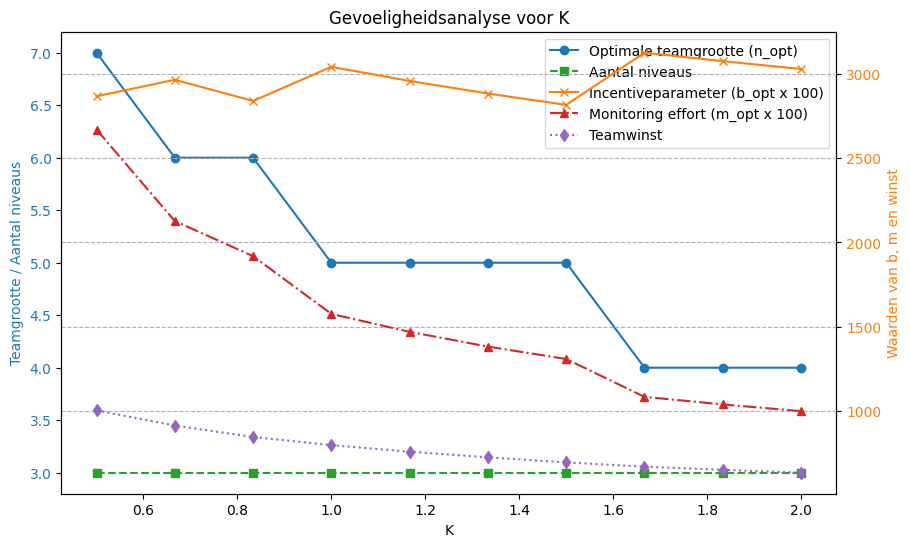

In [25]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def team_profit_value(b, m, n, q, c, r, A, y, K, a):
    """
    Bereken de winst van een team met:
      - n werknemers,
      - incentiveparameter b (waardoor e = b/c),
      - monitoring effort m.
      
    Parameters:
      b : float
          Incentivecoëfficiënt in het lineaire contract.
      m : float
          Monitoring effort van de manager (m > 0).
      n : int
          Teamgrootte (aantal werknemers in het team).
      q : float
          Output per eenheid inspanning.
      c : float
          Kosten van inspanning (hogere c betekent duurdere inspanning).
      r : float
          Risicoaversie van werknemers.
      A : float
          Schaalparameter in de variantiefunctie.
      y : float
          Exponent in de variantiefunctie (y > 1).
      K : float
          Parameter voor de monitoringkosten (bijv. K*m^2).
      a : float
          Vast looncomponent.
    
    Formule:
      Profit = n * ( q*(b/c) - (a + b^2/c) )
             - 0.5 * r * n * b^2 * (A * n^y / m)
             - K * m^2.
    """
    e = b / c  # Inspanningsniveau
    wage = a + (b**2) / c
    risk_cost = 0.5 * r * b**2 * (A * n**y / m)
    profit = n * (q * e - wage) - risk_cost - K * m**2
    return profit

def neg_team_profit(x, n, q, c, r, A, y, K, a):
    """
    Negatieve winst (om te maximaliseren team_profit_value).
    x bevat [b, m].
    """
    b, m = x
    if b <= 0 or m <= 0:
        return 1e6
    return -team_profit_value(b, m, n, q, c, r, A, y, K, a)

def optimize_team_for_n(n, q, c, r, A, y, K, a):
    """
    Optimaliseer de keuze van incentiveparameter (b) en monitoring effort (m)
    voor een gegeven teamgrootte n.
    
    Geeft terug:
      dict met: 'n', 'b_opt', 'm_opt' en 'profit'
    """
    x0 = [1.0, 1.0]  # Startwaarden
    bounds = [(1e-3, None), (1e-3, None)]
    
    res = minimize(neg_team_profit, x0, args=(n, q, c, r, A, y, K, a), bounds=bounds, method='L-BFGS-B')
    if res.success:
        b_opt, m_opt = res.x
        profit = team_profit_value(b_opt, m_opt, n, q, c, r, A, y, K, a)
    else:
        b_opt, m_opt, profit = None, None, -np.inf
    return {'n': n, 'b_opt': b_opt, 'm_opt': m_opt, 'profit': profit}

def find_optimal_team_parameters(q, c, r, A, y, K, a, n_range):
    """
    Zoek over een reeks mogelijke teamgroottes (n_range) naar de optimale teamgrootte 
    en de bijbehorende parameters.
    
    Geeft terug:
      best_result : dict met de beste waarden (maximale winst)
      all_results : lijst van resultaten voor elke n in n_range.
    """
    results = []
    for n in n_range:
        res = optimize_team_for_n(n, q, c, r, A, y, K, a)
        results.append(res)
    best_result = max(results, key=lambda x: x['profit'])
    # Beperk de optimale teamgrootte tot 20
    best_result['n'] = min(best_result['n'], 20)
    return best_result, results

def build_hierarchy_detailed(N_total, team_opt_params):
    """
    Bouw een hiërarchie op basis van de optimale teamgrootte (n_opt).
    Elke manager houdt toezicht op een team van grootte n_opt.
    
    Geeft terug:
      levels : lijst met het aantal managers op elk niveau.
    """
    n_opt = team_opt_params['n']
    levels = []
    current = 1  # Topmanager
    levels.append(current)
    while current < N_total:
        current *= n_opt
        levels.append(current)
        if current >= N_total:
            break
    return levels

def sensitivity_analysis_detailed(param_name, param_values, default_params, n_range, N_total):
    """
    Voer een gevoeligheidsanalyse uit op het gedetailleerde model door één parameter te variëren.
    
    Parameters:
      param_name : str
          Naam van de te variëren parameter (bijv. 'q', 'c', 'r', 'A', 'y', 'K' of 'a').
      param_values : array-like
          Reeks waarden voor de variable parameter.
      default_params : dict
          Standaardwaarden voor {q, c, r, A, y, K, a}.
      n_range : array-like
          Reeks mogelijke teamgroottes (bijv. np.arange(2, 50)).
      N_total : int
          Totaal aantal werknemers (of eenheden) op het laagste niveau.
    
    Geeft terug:
      results : lijst van dicts met:
          'param_value', 'n_opt', 'b_opt', 'm_opt', 'profit' en 'num_levels'
    """
    results = []
    for val in param_values:
        params = default_params.copy()
        params[param_name] = val
        best_team, _ = find_optimal_team_parameters(params['q'], params['c'], params['r'], 
                                                      params['A'], params['y'], params['K'], params['a'], 
                                                      n_range)
        hierarchy = build_hierarchy_detailed(N_total, best_team)
        num_levels = len(hierarchy)
        results.append({
            'param_value': val,
            'n_opt': best_team['n'],
            'b_opt': best_team['b_opt'],
            'm_opt': best_team['m_opt'],
            'profit': best_team['profit'],
            'num_levels': num_levels
        })
    return results

# --------------------------
# Default parameter waarden:
# --------------------------
default_params = {
    'q': 100,  # Output per werknemer, omzet
    'c': 6,    # Kosten van inspanning (hogere c betekent duurdere inspanning)
    'r': 0.3,  # Risicoaversie (hoe hoger, des te meer premie werknemers eisen)
    'A': 0.45,  # Schaalparameter in de variantiefunctie (hogere waarde = meer onzekerheid met teamgrootte)
    'y': 3,    # Exponent (y > 1), die aangeeft hoe snel de onzekerheid toeneemt met teamgrootte
    'K': 1,  # Monitoringkostenparameter; hoger K betekent duurdere monitoring
    'a': 45   # Vaste looncomponent, onafhankelijk van prestaties
}
N_total = 10                 # Totaal aantal werknemers op het laagste niveau
n_range = np.arange(2, 50)   # Mogelijke teamgroottes: van 2 tot 50

# --------------------------
# RESULTATEN voor standaardwaarden
# --------------------------
best_team_default, all_results_default = find_optimal_team_parameters(
    default_params['q'], default_params['c'], default_params['r'], 
    default_params['A'], default_params['y'], default_params['K'], default_params['a'], 
    n_range
)
hierarchy_default = build_hierarchy_detailed(N_total, best_team_default)
num_levels_default = len(hierarchy_default)

print("Resultaten voor de standaardwaarden:")
print("Optimale teamgrootte (n_opt):", best_team_default['n'])
print("Optimale incentiveparameter (b_opt):", best_team_default['b_opt'])
print("Optimale monitoring effort (m_opt):", best_team_default['m_opt'])
print("Maximale teamwinst:", best_team_default['profit'])
print("Aantal niveaus in hiërarchie:", num_levels_default)

# --------------------------
# Gevoeligheidsanalyse
# --------------------------
# Definieer bereik voor de variabele parameters:
param_ranges = {
    'q': np.linspace(50, 150, 10), 
    'a': np.linspace(5, 50, 10),
    'c': np.linspace(3, 7, 10),
    'r': np.linspace(0.1, 0.5, 10),
    'A': np.linspace(0.1, 1.0, 10),
    'y': np.linspace(1.5, 3.5, 10),
    'K': np.linspace(0.5, 2.0, 10)
}

# Voer de gevoeligheidsanalyse voor elke parameter uit en plot de resultaten:
for param, values in param_ranges.items():
    results = sensitivity_analysis_detailed(param, values, default_params, n_range, N_total)
    
    # Haal resultaten op:
    param_vals = [res['param_value'] for res in results]
    n_opts = [res['n_opt'] for res in results]
    b_opts = [res['b_opt'] for res in results]
    m_opts = [res['m_opt'] for res in results]
    profits = [res['profit'] for res in results]
    num_levels = [res['num_levels'] for res in results]
    
    # Schaalfactoren voor betere visualisatie:
    scale_factor_b = 100  # Schaal voor incentiveparameter
    scale_factor_m = 100  # Schaal voor monitoring effort

    # Creëer een figuur met twee y-assen:
    fig, ax1 = plt.subplots(figsize=(10,6))
    
    # Linker y-as: optimale teamgrootte en aantal hiërarchische niveaus
    ax1.plot(param_vals, n_opts, marker='o', color='C0', label='Optimale teamgrootte (n_opt)')
    ax1.plot(param_vals, num_levels, marker='s', linestyle='--', color='C2', label='Aantal niveaus')
    ax1.set_xlabel(param)
    ax1.set_ylabel("Teamgrootte / Aantal niveaus", color='C0')
    ax1.tick_params(axis='y', labelcolor='C0')
    
    # Rechter y-as: incentiveparameter, monitoring effort en teamwinst
    ax2 = ax1.twinx()
    ax2.plot(param_vals, [x * scale_factor_b for x in b_opts], marker='x', linestyle='-', color='C1', 
             label=f'Incentiveparameter (b_opt x {scale_factor_b})')
    ax2.plot(param_vals, [x * scale_factor_m for x in m_opts], marker='^', linestyle='-.', color='C3', 
             label=f'Monitoring effort (m_opt x {scale_factor_m})')
    ax2.plot(param_vals, profits, marker='d', linestyle=':', color='C4', label='Teamwinst')
    ax2.set_ylabel("Waarden van b, m en winst", color='C1')
    ax2.tick_params(axis='y', labelcolor='C1')
    
    # Combineer de legendes van beide assen:
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')
    
    plt.title(f"Gevoeligheidsanalyse voor {param}")
    plt.grid(True, which="both", ls="--")
    plt.show()
